## Part 2: The Restaurnts Demo

### About PyDP
The PyDP package provides access to Differential Privacy algorithms in Python. This example uses the 1.0 version of the package that has the following limitations:

1. This version only supports [Google's Differential Privacy library](https://github.com/google/differential-privacy).
2. Laplace noise generation technique.
3. Supports only integer and floating point values

### What's in this Tutorial
Aim to display all the functionlity of PyDP using a psudo real-world example.

We take a fictional case of a restaurant owned by Alice which has been asked to prepare some statisitcs by the investors and also wants to share the same with their advvertisment partner. But while doing that, Alice knows about hyper-targeting of ads that's being done today and wants to avoid this (since the advertiser also has some credit card data too).

She releases two statisitcs:
1. Count of people who come during each day of week
2. Revenue on each day of business. 


In [20]:
! pip install python-dp

In [21]:
import pydp as dp
from pydp.algorithms.laplacian import BoundedSum, Count

In [22]:
import math
import statistics as s
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import numpy as np

#### Some basic assumptions

In [23]:
# Time when visitors start entering the restaurant (900 represents 9:00 AM)
OPENING_HOUR = 900

# Time when visitors finish entering the restaurant (2000 represents 20:00 PM)
CLOSING_HOUR = 2000

# A python list of valid work hours when visitors can come to the restaurant.
VALID_HOURS = list(range(OPENING_HOUR, CLOSING_HOUR + 1))

# Cap the maximum number of visiting days at 3 per each visitor (any number above will not be taken into account)
COUNT_MAX_CONTRIBUTED_DAYS = 4

# Cap the maximum number of visiting days at 4 per each visitor (any number above will not be taken into account)
SUM_MAX_CONTRIBUTED_DAYS = 4

# Expected minimum amount of money (in Euros) to be spent by a visitor per a single visit
MIN_EUROS_SPENT = 0

# Expected maximum amount of money (in Euros) to be spent by a visitor per a single visit
MAX_EUROS_SPENT_1 = 50
MAX_EUROS_SPENT_2 = 65

_epsilon = math.log(3)

### Loading the data

In [24]:
# Loading the dataset
_day_visits = pd.read_csv('https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial_2-restaurant_demo/week_data.csv', sep=",")
_day_visits.head()

,VisitorId,Time entered,Time spent (minutes),Money spent (euros),Day
0,580,9:27:00 AM,29,17,1
1,1215,9:16:00 AM,45,18,1
2,448,11:55:00 AM,12,16,1
3,125,10:47:00 AM,27,20,1
4,484,11:08:00 AM,35,13,1


### The concept of l0 and linf sensitivity 

- l0 sensitivity: Numer of times a unique user identificaition can contribute to different partitions.

- linf sensitivity: Number of times a uuid appears in a partition.

#### Why are we doing this?
Utility function to aggregate linf sensitivity in this case.

In [25]:
# Note: PyDP expects that when you set l0 and linf sensitivity,
# your data actually adhers to these limits you set
def bound_visits_per_week(df, limit):
    """Utility function to modify the input dataframes. 
    
    Makes sure that each visitor only contributes at most 3 visits per week,
    Returns an updated dataframe 
    """

    # Shuffle dataframe
    df = df.sample(frac=1)

    # Store results in new dataframe
    updated_df = pd.DataFrame(columns=df.columns)
    df_idx = 0

    # Keep track of visits per visitor and make sure it doesn't go above the limit
    # {visitor id: # of times it has visited the restaurant}
    id_to_visited = defaultdict(int)

    for index in df.index:
        if id_to_visited[df.loc[index]["VisitorId"]] < limit:
            updated_df.loc[df_idx] = df.loc[index]
            df_idx += 1
            id_to_visited[df.loc[index]["VisitorId"]] += 1

    return updated_df

### Count customers in a week
Get Count of how many times customer vist on each day of a week

In [26]:
def get_non_private_counts_per_day() -> dict:
        """Compute the number of visits per day without any differential privacy. 
        
        Return a dictionary mapping days to number of visits
        """
        day_counts = dict()

        for day in _day_visits["Day"].unique():
            day_counts[day] = _day_visits[_day_visits["Day"] == day][
                "Day"
            ].count()

        return day_counts    

In [27]:
def get_private_counts_per_day(epsilon: float = _epsilon) -> dict:
        """Compute an anonymized (within a given threshold of epsilon) version of the number of visits per day. 
        
        Return a dictionary mapping days to number of visits
        """
        # Pre-process the data set: limit the number of days contributed by a visitor to COUNT_MAX_CONTRIBUTED_DAYS
        day_visits = bound_visits_per_week(_day_visits, COUNT_MAX_CONTRIBUTED_DAYS)

        day_counts = dict()

 
        x = Count(
            epsilon=_epsilon, l0_sensitivity=COUNT_MAX_CONTRIBUTED_DAYS, dtype="int"
        )

        # Note: we are using up all epilon for the calculation
        for day in day_visits["Day"].unique():
            # Can use either quick_result or a combination of add_entries() and result()
            day_counts[day] = x.quick_result(
                data=list(day_visits[day_visits["Day"] == day]["Day"])
            )

        return day_counts

    

In [28]:
def count_visits_per_day() -> tuple:
        """Compute the number of visits per hour of day and return two dictionaries 
        that map a day to the number of visits in that day. 
        
        The first dictionary is the count calculation without any differential privacy, 
        The second one uses the PyDP library for a private calculation
        """
        non_private_counts = get_non_private_counts_per_day()
        private_counts = get_private_counts_per_day()

        return non_private_counts, private_counts

In [29]:
np_count_day, p_count_day, np_count_data_p = count_visits_per_day()
np_count_day = OrderedDict(sorted(np_count_day.items()))
p_count_day = OrderedDict(sorted(p_count_day.items()))

print("Visits per day:")
print("Without differential privacy:", np_count_day)
print("With differential privacy:", p_count_day)

Visits per day:
Without differential privacy: OrderedDict([(1, 300), (2, 300), (3, 400), (4, 400), (5, 450), (6, 500), (7, 500)])
With differential privacy: OrderedDict([(1, 299), (2, 287), (3, 384), (4, 408), (5, 441), (6, 497), (7, 502)])


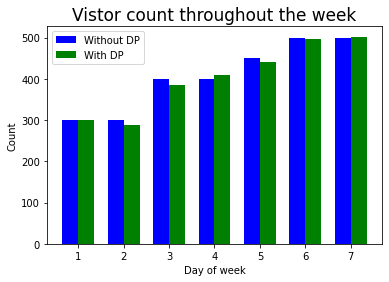

In [30]:
ax = plt.subplot(111)
X = np.arange(len(np_count_day.keys()))
width = 0.35  # the width of the bars

ax.bar(X-width/2, np_count_day.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_count_day.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Count')
ax.set_xlabel('Day of week')
plt.xticks(X, np_count_day.keys())
plt.title("Vistor count throughout the week", fontsize=17)
plt.show()

### Revenue on each day of the week

In [31]:
def get_non_private_sum_revenue() -> dict:
        """Compute the revenue per day of visits without any differential privacy. 
        
        Return a dictionary mapping days to revenue
        """
        day_revenue = dict()

        for day in _day_visits["Day"].unique():
            day_revenue[day] = _day_visits[_day_visits["Day"] == day][
                "Money spent (euros)"
            ].sum()

        return day_revenue

In [32]:
def get_private_sum_revenue(epsilon: float = _epsilon) -> dict:
        """Compute an anonymized (within a given threshold of epsilon) version of the revenue per day. Return a dictionary mapping days to revenue"""
        # Pre-process the data set: limit the number of days contributed by a visitor to SUM_MAX_CONTRIBUTED_DAYS
        day_visits = bound_visits_per_week(_day_visits, SUM_MAX_CONTRIBUTED_DAYS)

        day_revenue = dict()

        x = BoundedSum(
            epsilon,
            MIN_EUROS_SPENT,
            MAX_EUROS_SPENT_1,
            l0_sensitivity=SUM_MAX_CONTRIBUTED_DAYS,
        )

        for day in day_visits["Day"].unique():

            x.reset()
            # Can use either quick_result or a combination of add_entries() and result()
            x.add_entries(
                data=list(day_visits[day_visits["Day"] == day]["Money spent (euros)"])
            )
            day_revenue[day] = int(x.result())

        return day_revenue


In [33]:
def sum_revenue_per_day() -> tuple:
        """Compute the restaurant's daily revenue for the whole week.  
        
        The first dictionary is the count calculation without any differential privacy, 
        while the second one uses the PyDP library for a private calculation
        """
        non_private_sum = get_non_private_sum_revenue()
        private_sum = get_private_sum_revenue()

        return non_private_sum, private_sum


In [34]:

np_sum_day, p_sum_day = sum_revenue_per_day()
np_sum_day = OrderedDict(sorted(np_sum_day.items()))
p_sum_day = OrderedDict(sorted(p_sum_day.items()))
print("Revenue per day:")
print("Without differential privacy:", np_sum_day)
print("With differential privacy:", p_sum_day)
print("-----------------------------------")

Revenue per day:
Without differential privacy: OrderedDict([(1, 8678), (2, 8696), (3, 12088), (4, 12079), (5, 13765), (6, 16576), (7, 16500)])
With differential privacy: OrderedDict([(1, 8478), (2, 8234), (3, 12017), (4, 11539), (5, 13676), (6, 16225), (7, 16301)])
-----------------------------------


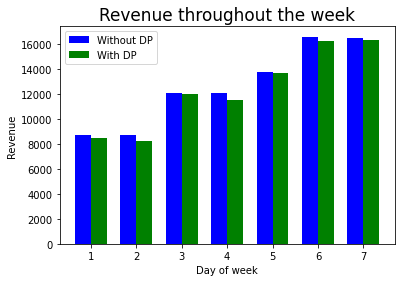

In [35]:
ax = plt.subplot(111)
X = np.arange(len(np_sum_day.keys()))
width = 0.35  # the width of the bars
ax.bar(X-width/2, np_sum_day.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_sum_day.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Revenue')
ax.set_xlabel('Day of week')
plt.xticks(X, np_sum_day.keys())
plt.title("Revenue throughout the week", fontsize=17)
plt.show()

In the previous calculation, we assumed that each customer just visits once a week and did the calculation accordingly.
But sometimes, they visit more than once a week, and hence we need to add a bit more noise for same. 




A visitor typically enters the restaurant twice a day and pays 10 euros for breakfast and 50 euros for dinner. The lower and upper bounds should be set to 10 and 50 while maxContributionsPerPartitions equals 2. If we let the library calculate the sensitivity of sum (i.e., how much a single visitor can impact the final result), this will result in sensitivity of 100 while the actual sensitivity is 60 (the higher the sensitivity is - the more noise is added). In such a case, it makes sense to pre-aggregate all visits, and provide a single contribution with adjusted lower and upper bounds (in our example, sum-up 10 and 50 and set the upper bound to 60).


In [36]:
def get_private_sum_revenue_with_preaggregation(
        epsilon: float = _epsilon
    ) -> dict:
        """Compute an anonymized (within a given threshold of epsilon) version of the revenue per day. 
        
        Before performing the computation, 
        we pre-aggregate each visitor' spending for the day. Return a dictionary mapping days to revenue
        """

        # Pre-process the data set: limit the number of days contributed by a visitor to SUM_MAX_CONTRIBUTED_DAYS
        day_visits = bound_visits_per_week(_day_visits, SUM_MAX_CONTRIBUTED_DAYS)

        day_revenue = dict()


        x = BoundedSum(
            epsilon,
            MIN_EUROS_SPENT,
            MAX_EUROS_SPENT_2,
            l0_sensitivity=SUM_MAX_CONTRIBUTED_DAYS,
        )

        for day in day_visits["Day"].unique():
            # For each visitor, pre-aggregate their spending for the day.
            visits_on_day = day_visits[day_visits["Day"] == day][
                ["VisitorId", "Money spent (euros)"]
            ]
            visitor_to_spending = dict()

            for visitor in visits_on_day["VisitorId"].unique():
                visitor_to_spending[visitor] = visits_on_day[
                    visits_on_day["VisitorId"] == visitor
                ]["Money spent (euros)"].sum()

            spending = list(visitor_to_spending.values())

            x.reset()
            # Can use either quick_result or a combination of add_entries() and result()
            x.add_entries(data=spending)
            day_revenue[day] = int(x.result())

        return day_revenue




In [37]:
def sum_revenue_per_day_with_preaggregation() -> tuple:
        """Calculates the restaurant's daily revenue for the whole week, while
        pre-agreggating each visitor's spending before calculating the
        BoundedSum with PyDP.
        
        The first dictionary is the count calculation without any differential privacy, 
        while the second one uses the PyDP library for a private calculation
        """
        non_private_sum = get_non_private_sum_revenue()
        private_sum = get_private_sum_revenue_with_preaggregation()

        return non_private_sum, private_sum

In [38]:
np_sum_day_pa, p_sum_day_pa = sum_revenue_per_day_with_preaggregation()
np_sum_day_pa = OrderedDict(sorted(np_sum_day_pa.items()))
p_sum_day_pa = OrderedDict(sorted(p_sum_day_pa.items()))
print("Revenue per day with preaggregation:")
print("Without differential privacy:", np_sum_day_pa)
print("With differential privacy:", p_sum_day_pa)
print("-----------------------------------")

Revenue per day with preaggregation:
Without differential privacy: OrderedDict([(1, 8678), (2, 8696), (3, 12088), (4, 12079), (5, 13765), (6, 16576), (7, 16500)])
With differential privacy: OrderedDict([(1, 8716), (2, 8826), (3, 12132), (4, 11797), (5, 14105), (6, 16437), (7, 16362)])
-----------------------------------


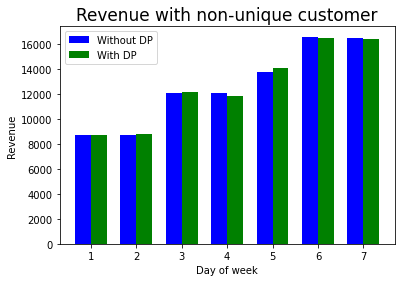

In [39]:
ax = plt.subplot(111)
X = np.arange(len(np_sum_day_pa.keys()))
width = 0.35  # the width of the bars

ax.bar(X-width/2, np_sum_day_pa.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_sum_day_pa.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Revenue')
ax.set_xlabel('Day of week')
plt.xticks(X, np_sum_day_pa.keys())
plt.title("Revenue with non-unique customer", fontsize=17)
plt.show()

Further Readging: 
1. How did we calculate l0 and linf sensitivity Bounded functions: [Differentially Private SQL with Bounded User Contribution](https://arxiv.org/pdf/1909.01917.pdf)
2. [Restaurants Demo by Google](https://github.com/google/differential-privacy/tree/main/examples/java)